In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
def evolveStates(initStates, timeSteps, precessionFreq):
    # Get array sizes for convinience
    num_states = np.size(initStates)
    num_timeSteps = np.size(timeSteps)
    
    # Calculate the phase advancements
    added_phase = 360 * timeSteps * precessionFreq
    # Copy initial states across different timesteps
    states = np.transpose(np.reshape(np.tile(initStates, num_timeSteps), [num_timeSteps,num_states]))
    # Copy the phases to be added across different states
    phases = np.reshape(np.tile(added_phase, num_states), [num_states,num_timeSteps])
    
    return states + phases

In [3]:
def applyRandomPhaseJumps(states, timeSteps, jumpPeriod, jumpAmplMean, jumpAmplStdev):
    # Get array sizes for convinience
    num_states = np.size(states[:,0])
    num_timeSteps = np.size(timeSteps)
    # Jump parameters
    deltaT = np.max(timeSteps) - np.min(timeSteps)
    averageNumJumps = deltaT / jumpPeriod
    # Jump statistics
    numJumpStats = np.zeros(num_states)
    totalPhaseShiftStats = np.zeros(num_states)
    
    # Loop through each state in order to apply jump events
    for stateIndex in np.arange(1, num_states+1, 1)-1:
        # Number of jumps determined by a Poisson distribution
        numJumps = np.random.poisson(lam=averageNumJumps)
        numJumpStats[stateIndex] = numJumps
        # Generate some jump event timestamps
        jumpEvents = generateEvents(timeSteps, numJumps)
        # Store phase jump amplitudes
        jumpAmplStats = np.array([])
        # Loop through the jump events
        for jumpTS in jumpEvents:
            # Apply each jump
            jumpAmpl = np.random.normal(loc=jumpAmplMean, scale=jumpAmplStdev)
            jumpAmplStats = np.append(jumpAmplStats, jumpAmpl)
            states[stateIndex] = applyJump(states[stateIndex], timeSteps, jumpTS, jumpAmpl)
        # Total phase shift per state
        totalPhaseShiftStats[stateIndex] = np.sum(jumpAmplStats)
    
    return states, numJumpStats, totalPhaseShiftStats

In [4]:
def applyJump(state, timeSteps, timeStamp, jumpAmpl):
    # Index of first timeStep greater than timeStamp
    jumpIndex = np.argmax(timeSteps>=timeStamp)
    # Copy of state
    newState = state
    # Update state with jump after timeStamp
    newState[jumpIndex:np.size(newState)] = newState[jumpIndex:np.size(newState)] + jumpAmpl
    return newState

In [5]:
def generateEvents(timeSteps, numEvents):
    return np.random.uniform(low=np.min(timeSteps), high=np.max(timeSteps), size=numEvents)

# Rydberg - NH3 collision simulation

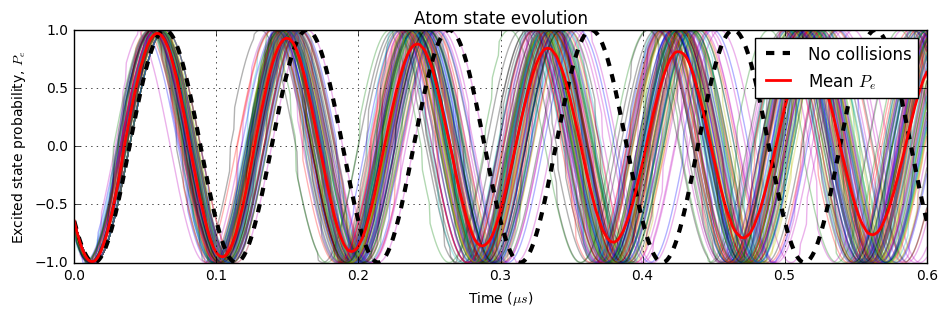

In [40]:
numAtoms = 100
initPhase = 220
initStates = np.zeros(numAtoms) + initPhase
timeSteps = np.linspace(0,0.6,1000) # us
precessionFreq = 10.0               # MHz
jumpPeriod = 0.03                    # us
jumpAmplMean = 10.0                  # degrees
jumpAmplStdev = 2.0                 # degrees

evolved_states = evolveStates(initStates, timeSteps, precessionFreq)
[collision_states, numJumpStats, totalPhaseShiftStats] = applyRandomPhaseJumps(
    evolved_states, timeSteps, jumpPeriod, jumpAmplMean, jumpAmplStdev)

matplotlib.rcParams['figure.figsize'] = (11.0, 3.0)

plotStartI = int(np.floor(np.size(timeSteps) * 0.00 ))
plotEndI   = int(np.floor(np.size(timeSteps) * 1.00 ))

for stateIndex in np.arange(1, numAtoms+1, 1)-1:
    plt.plot(timeSteps[plotStartI:plotEndI], np.sin(np.radians(collision_states[stateIndex]))[plotStartI:plotEndI],
             alpha=0.3)
    
no_collisions = np.sin(2*np.pi * timeSteps * precessionFreq + np.radians(initPhase) )
plt.plot(timeSteps[plotStartI:plotEndI], no_collisions[plotStartI:plotEndI], 'k--', lw=3, label='No collisions')
mean_pe = np.mean(np.sin(np.radians(collision_states)), axis=0)
plt.plot(timeSteps[plotStartI:plotEndI], mean_pe[plotStartI:plotEndI], 'r-', lw=2, label='Mean $P_e$')

plt.xlabel('Time ($\mu s$)')
plt.ylabel('Excited state probability, $P_e$')
plt.title('Atom state evolution')
plt.grid()
plt.legend()

# Statistics

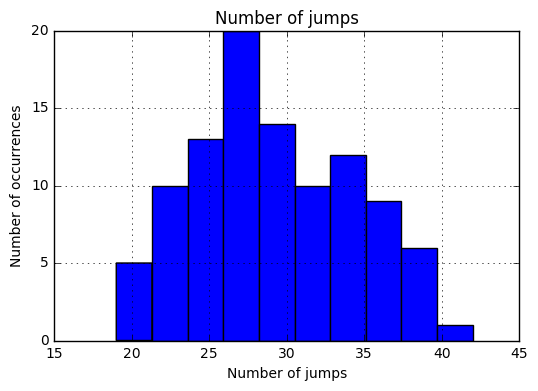

In [7]:
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
plt.hist(numJumpStats)
plt.xlabel('Number of jumps')
plt.ylabel('Number of occurrences')
plt.title('Number of jumps')
plt.grid()

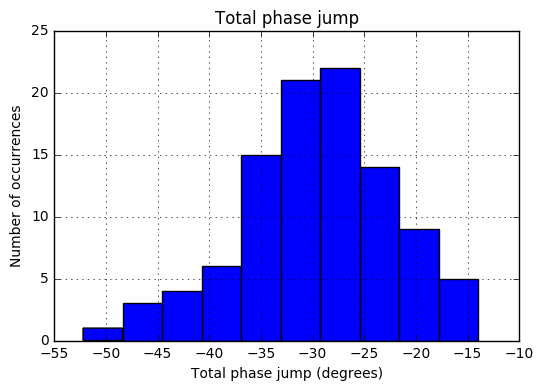

In [409]:
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
plt.hist(totalPhaseShiftStats)
plt.xlabel('Total phase jump (degrees)')
plt.ylabel('Number of occurrences')
plt.title('Total phase jump')
plt.grid()

# Curve fit

In [410]:
def decayingSinModel(time, freq, decay, amp):
    # Linearly decaying sinusoidal function
    return amp * np.exp(-time/decay) * np.sin(2*np.pi*( freq*time ))

The fitted value of  Frequency  is  9.97300400151  with error  5.35833147161e-06
The fitted value of  Decay  is  356.648166735  with error  8.49160293202
The fitted value of  Amplitude  is  1.00040008491  with error  0.000115698000935


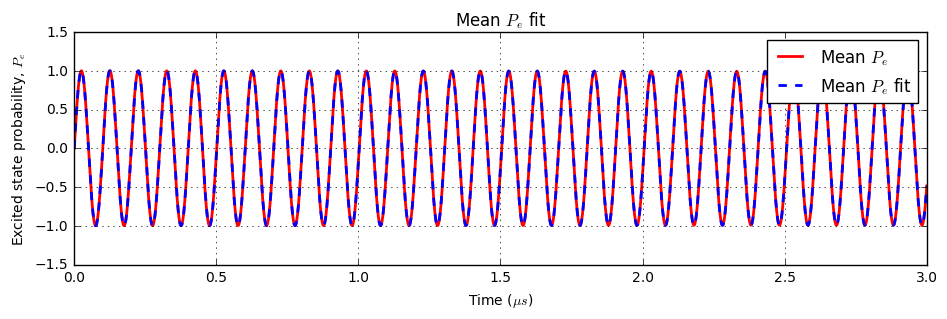

In [411]:
freq_guess = precessionFreq
decay_guess = 10
amp_guess = 1
guess = [freq_guess, decay_guess, amp_guess]
popt,pcov = curve_fit(decayingSinModel, timeSteps, mean_pe, p0=guess)

perr = np.sqrt(np.diag(pcov))
params = ['Frequency', 'Decay', 'Amplitude']

for idx in range(len(params)):
    print( "The fitted value of ", params[idx], " is ", popt[idx], " with error ", perr[idx] )

matplotlib.rcParams['figure.figsize'] = (11.0, 3.0)

mean_pe_fit = decayingSinModel(timeSteps, *popt)
plt.plot(timeSteps, mean_pe, 'r-', lw=2, label='Mean $P_e$')
plt.plot(timeSteps, mean_pe_fit, 'b--', lw=2, label='Mean $P_e$ fit')

plt.xlabel('Time ($\mu s$)')
plt.ylabel('Excited state probability, $P_e$')
plt.title('Mean $P_e$ fit')
plt.grid()
plt.legend()

In [377]:
a = np.array([])

In [375]:
a = np.append(a, 1)
a = np.append(a, 3)
a = np.append(a, 2)
a

array([ 1.,  3.,  2.])